<a href="https://colab.research.google.com/github/sriksmachi/sriksml/blob/main/reinforcement-learning/ppo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install gym==0.22  > /dev/null 2>&1
%pip install tensorflow_probability  > /dev/null 2>&1
%pip install tensorflow  > /dev/null 2>&1
%pip install pygame  > /dev/null 2>&1

In [4]:
import tensorflow as tf
import numpy as np
import gym
import tensorflow_probability as tfp
import tensorflow.keras.losses as kls
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


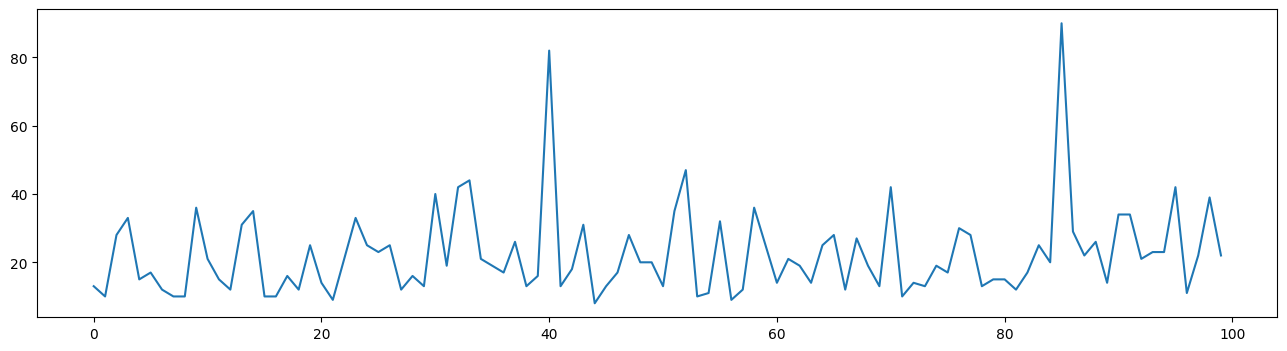

In [12]:
# Lets create a baseine pendulum environment with random agent and run it for 100 episodes
env = gym.make('CartPole-v0')
total_rewards = []
for i in range(100):
  env.reset()
  rewards = []
  terminal = False
  while not terminal:
    action = env.action_space.sample()
    observation, reward, terminal, info = env.step(action)
    rewards.append(reward)
  total_rewards.append(np.sum(rewards))
plt.figure(0, figsize=(16,4))
plt.plot(total_rewards)

In [ ]:
class PPOMemory():

  def __init__(self, batch_size):
    self.states = []
    self.actions = []
    self.probs = []
    self.values = []
    self.rewards = []
    self.dones = []


  def store_memory(self, state, action, probs, vals, reward, done):
    self.states.append(state)
    self.actions.append(action)
    self.probs.append(probs)
    self.values.append(vals)
    self.rewards.append(reward)
    self.dones.append(done)



In [15]:
# Actor Network
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten

class actor(tf.keras.Model):
  def __init__(self, n_actions, fc1_dims=128, fc2_dims=64):
    super(actor, self).__init__()
    self.fc1 = tf.keras.layers.Dense(fc1_dims,activation='relu')
    self.fc2 = tf.keras.layers.Dense(fc2_dims,activation='relu')
    self.flatten = Flatten()
    self.a = tf.keras.layers.Dense(n_actions,activation='softmax')

  def call(self, input_data):
    x = self.fc1(input_data)
    x = self.flatten(x)
    x = self.fc2(x)
    a = self.a(x)
    return a

In [16]:
class critic(tf.keras.Model):
  def __init__(self, fc1_dims=256, fc2_dims=256):
    super(critic, self).__init__()
    self.fc1 = tf.keras.layers.Dense(fc1_dims,activation='relu')
    self.fc2 = tf.keras.layers.Dense(fc2_dims,activation='relu')
    self.flatten = Flatten()
    # critic network outputs the Q value
    self.a = tf.keras.layers.Dense(1,activation=None)

  def call(self, input_data):
    x = self.fc1(input_data)
    x = self.flatten(x)
    x = self.fc2(x)
    a = self.a(x)
    return a

In [7]:
class agent():
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003,
                 gae_lambda=0.95, policy_clip=0.2, batch_size=64,
                 n_epochs=10, chkpt_dir='models/'):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda
        self.chkpt_dir = chkpt_dir

        self.actor = actor(n_actions)
        self.actor.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=alpha))

        self.critic = critic()
        self.critic.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=alpha))
        self.memory = PPOMemory(batch_size)

    def store(self, state, action, probs, vals, rewards, done):
     self.memory.store_memory(state, action, probs, vals, reward, done)

    # agent's action function
    def act(self,state):
        # convert state into tensor
        prob = self.actor(np.array([state]))
        prob = prob.numpy()
        dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32)
        action = dist.sample()
        return int(action.numpy()[0])

    def actor_loss(self, probs, actions, adv, old_probs, closs):
        probability = probs
        entropy = tf.reduce_mean(tf.math.negative(tf.math.multiply(probability,tf.math.log(probability))))
        sur1 = []
        sur2 = []
        for pb, t, op,a  in zip(probability, adv, old_probs, actions):
                        t =  tf.constant(t)
                        ratio = tf.math.divide(pb[a],op[a])
                        s1 = tf.math.multiply(ratio,t)
                        s2 =  tf.math.multiply(tf.clip_by_value(ratio, 1.0 - self.clip_param, 1.0 + self.clip_param),t)
                        sur1.append(s1)
                        sur2.append(s2)
        sr1 = tf.stack(sur1)
        sr2 = tf.stack(sur2)
        loss = tf.math.negative(tf.reduce_mean(tf.math.minimum(sr1, sr2)) - closs + 0.001 * entropy)
        return loss

    def learn(self, states, actions,  adv , old_probs, discnt_rewards):
        discnt_rewards = tf.reshape(discnt_rewards, (len(discnt_rewards),))
        adv = tf.reshape(adv, (len(adv),))
        old_p = old_probs
        old_p = tf.reshape(old_p, (len(old_p),2))
        with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
            p = self.actor(states, training=True)
            v =  self.critic(states,training=True)
            v = tf.reshape(v, (len(v),))
            td = tf.math.subtract(discnt_rewards, v)
            c_loss = 0.5 * kls.mean_squared_error(discnt_rewards, v)
            a_loss = self.actor_loss(p, actions, adv, old_probs, c_loss)

        grads1 = tape1.gradient(a_loss, self.actor.trainable_variables)
        grads2 = tape2.gradient(c_loss, self.critic.trainable_variables)
        self.a_opt.apply_gradients(zip(grads1, self.actor.trainable_variables))
        self.c_opt.apply_gradients(zip(grads2, self.critic.trainable_variables))
        return a_loss, c_loss

In [8]:
def test_reward(env):
  total_reward = 0
  state = env.reset()
  done = False
  while not done:
    action = np.argmax(agentoo7.actor(np.array([state])).numpy())
    next_state, reward, done, _ = env.step(action)
    state = next_state
    total_reward += reward
  return total_reward

In [14]:
def preprocess1(states, actions, rewards, done, values, gamma):
    g = 0
    lmbda = 0.95
    returns = []
    for i in reversed(range(len(rewards))):
       delta = rewards[i] + gamma * values[i + 1] * done[i] - values[i]
       g = delta + gamma * lmbda * dones[i] * g
       returns.append(g + values[i])
    returns.reverse()
    adv = np.array(returns, dtype=np.float32) - values[:-1]
    adv = (adv - np.mean(adv)) / (np.std(adv) + 1e-10)
    states = np.array(states, dtype=np.float32)
    actions = np.array(actions, dtype=np.int32)
    returns = np.array(returns, dtype=np.float32)
    return states, actions, returns, adv


tf.random.set_seed(336699)
agentoo7 = agent()
steps = 1
ep_reward = []
total_avgr = []
target = False
best_reward = 0
avg_rewards_list = []

# stepping through
for s in range(steps):
  if target == True:
      break
  done = False
  state = env.reset()
  all_aloss = []
  all_closs = []
  rewards = []
  states = []
  actions = []
  probs = []
  dones = []
  values = []
  print("new episode")
  for e in range(128):
    action = agentoo7.act(state)
    value = agentoo7.critic(np.array([state])).numpy()
    next_state, reward, done, _ = env.step(action)
    dones.append(1-done)
    rewards.append(reward)
    states.append(state)
    actions.append(action)
    prob = agentoo7.actor(np.array([state]))
    probs.append(prob[0])
    values.append(value[0][0])
    state = next_state
    if done:
      env.reset()

  value = agentoo7.critic(np.array([state])).numpy()
  values.append(value[0][0])
  np.reshape(probs, (len(probs),2))
  probs = np.stack(probs, axis=0)
  states, actions,returns, adv  = preprocess1(states, actions, rewards, dones, values, 1)
  for epocs in range(10):
      al,cl = agentoo7.learn(states, actions, adv, probs, returns)

  avg_reward = np.mean([test_reward(env) for _ in range(5)])
  print(f"total test reward is {avg_reward}")
  avg_rewards_list.append(avg_reward)
  if avg_reward > best_reward:
        print('best reward=' + str(avg_reward))
        agentoo7.actor.save('model_actor_{}_{}'.format(s, avg_reward), save_format="tf")
        agentoo7.critic.save('model_critic_{}_{}'.format(s, avg_reward), save_format="tf")
        best_reward = avg_reward
  if best_reward == 200:
        target = True
  env.reset()
env.close()


new episode
total test reward is 62.0
best reward=62.0
